In [1]:
import pandas as pd
import numpy as np

In [2]:
berita = pd.read_json('berita.json')

In [3]:
berita.head()

,judul,kategori
0,Kini Produk Buatan Tangan UMKM Lebih Dicari da...,Bisnis
1,"Dongkrak Produktivitas Petani, Pupuk Indonesi...",Bisnis
2,Meikarta Mulai Topping Off Area Distrik 2,Bisnis
3,Sederet Inovasi Penyaluran BBM Pertamina di Us...,Bisnis
4,"Daftar Terbaru 50 Orang Terkaya di Indonesia, ...",Bisnis


In [4]:
kategori = pd.get_dummies(berita.kategori)

In [5]:
berita = pd.concat([berita, kategori], axis=1)
berita = berita.drop(columns='kategori')

In [6]:
berita

,judul,Bisnis,Health,Tekno
0,Kini Produk Buatan Tangan UMKM Lebih Dicari da...,1,0,0
1,"Dongkrak Produktivitas Petani, Pupuk Indonesi...",1,0,0
2,Meikarta Mulai Topping Off Area Distrik 2,1,0,0
3,Sederet Inovasi Penyaluran BBM Pertamina di Us...,1,0,0
4,"Daftar Terbaru 50 Orang Terkaya di Indonesia, ...",1,0,0
...,...,...,...,...
2137,Lebih Produktif Saat Bekerja di Rumah dengan M...,0,0,1
2138,5 Trik Rahasia WhatsApp Ini Patut Kamu Coba,0,0,1
2139,Ekonom UI: Kolaborasi Gojek dan Bank Jago Baka...,0,0,1
2140,Rahasia Main Game Free Fire Biar Selalu Booyah,0,0,1


# Bagian Baru

In [7]:
judul = berita['judul']
label = berita[['Bisnis', 'Health', 'Tekno']].values

In [8]:
from sklearn.model_selection import train_test_split
judul_latih, judul_test, label_latih, label_test = train_test_split(judul, label, test_size=0.2, random_state=42)

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [10]:
pad_type = 'pre'
trunc_type = 'pre'

# Tokenize our training data
tokenizer = Tokenizer(num_words=2000, oov_token='x')
tokenizer.fit_on_texts(judul_latih) 
tokenizer.fit_on_texts(judul_test)

# Encode training data sentences into sequences
sekuens_latih = tokenizer.texts_to_sequences(judul_latih)
sekuens_test = tokenizer.texts_to_sequences(judul_test)

# Get max training sequence length
maxlen = max([len(x) for x in sekuens_latih])

# Pad the training sequences
padded_latih = pad_sequences(sekuens_latih, padding=pad_type, truncating=trunc_type, maxlen=maxlen) 
padded_test = pad_sequences(sekuens_test, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

In [11]:
padded_latih[0]

array([   0,    0,    0,    3,    2,    4,    6, 1322,   81, 1138,   15,
         13,  188,  133,  275,   46, 1322], dtype=int32)

In [12]:
padded_test[0]

array([   0,    0,    0,    0,    0,    0,    0,  479,  205,   14,    3,
          2,   29, 1322,   19,   49,    6], dtype=int32)

In [13]:
import tensorflow as tf
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(input_dim=2000, output_dim=8),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(3, activation='softmax')
  ])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [14]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.9):
      print("\nAkurasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [15]:
num_epochs = 40
hist = model.fit(padded_latih, label_latih, epochs=num_epochs,
                    validation_data=(padded_test, label_test),
                    verbose=2, callbacks=[callbacks])

Epoch 1/40
54/54 - 3s - loss: 1.0870 - accuracy: 0.3824 - val_loss: 1.0825 - val_accuracy: 0.3846
Epoch 2/40
54/54 - 0s - loss: 1.0784 - accuracy: 0.3975 - val_loss: 1.0637 - val_accuracy: 0.5921
Epoch 3/40
54/54 - 0s - loss: 0.9415 - accuracy: 0.5721 - val_loss: 0.8316 - val_accuracy: 0.5897
Epoch 4/40
54/54 - 0s - loss: 0.7063 - accuracy: 0.6737 - val_loss: 0.6486 - val_accuracy: 0.6807
Epoch 5/40
54/54 - 0s - loss: 0.5286 - accuracy: 0.8004 - val_loss: 0.4868 - val_accuracy: 0.8462
Epoch 6/40
54/54 - 0s - loss: 0.3615 - accuracy: 0.8803 - val_loss: 0.4324 - val_accuracy: 0.8718
Epoch 7/40
54/54 - 0s - loss: 0.2949 - accuracy: 0.9083 - val_loss: 0.3988 - val_accuracy: 0.8438
Epoch 8/40
54/54 - 0s - loss: 0.2402 - accuracy: 0.9235 - val_loss: 0.3744 - val_accuracy: 0.8858
Epoch 9/40
54/54 - 1s - loss: 0.1779 - accuracy: 0.9451 - val_loss: 0.4081 - val_accuracy: 0.8951
Epoch 10/40
54/54 - 0s - loss: 0.1644 - accuracy: 0.9515 - val_loss: 0.3960 - val_accuracy: 0.8904
Epoch 11/40
54/54 -

In [16]:
import matplotlib.pyplot as plt

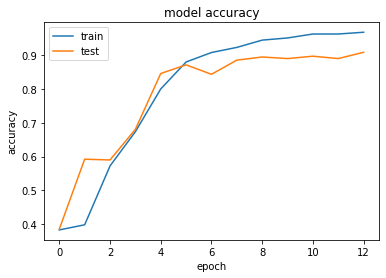

In [17]:
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

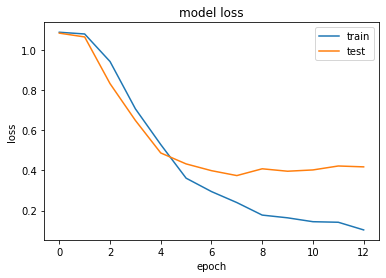

In [18]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [21]:
#function to make predictions
def make_predictions(model, tokenizer, ml):
  classes = ['Bisnis', 'Health', 'Tekno']
  while True:
    text = input('Masukkan judul berita: ')
    text = [text]
    t = tokenizer.texts_to_sequences(text)
    t = pad_sequences(t, padding='pre', truncating='pre', maxlen=ml)
    pred_t = model.predict(t)
    print('Prediksi: ', classes[pred_t.argmax()])
    lagi = input('Apakah ingin mencoba lagi? (y/n) :')
    if lagi=='n' or lagi=='N':
      break

In [27]:
make_predictions(model, tokenizer, maxlen)

Masukkan judul berita: Interaksi Keluarga Terhalang Pintu Kaca, Nirina Zubir Masih Harus Isolasi  Mandiri Akibat Covid-19
Prediksi:  Health
Apakah ingin mencoba lagi? (y/n) :y
Masukkan judul berita: 121 Tenaga Kesehatan di RSUD Tarakan Positif Corona
Prediksi:  Health
Apakah ingin mencoba lagi? (y/n) :y
Masukkan judul berita: iPhone 12 Lulus Sertifikasi TKDN, Pakai Jaringan 4G
Prediksi:  Tekno
Apakah ingin mencoba lagi? (y/n) :y
Masukkan judul berita: Manfaat Penggunaan Teknologi untuk Pendidikan
Prediksi:  Tekno
Apakah ingin mencoba lagi? (y/n) :y
Masukkan judul berita: Risiko meningkat, investasi obligasi korporasi masih menarik
Prediksi:  Bisnis
Apakah ingin mencoba lagi? (y/n) :y
Masukkan judul berita: Prospek investasi obligasi tahun 2021 masih menarik
Prediksi:  Bisnis
Apakah ingin mencoba lagi? (y/n) :y
Masukkan judul berita: Tahun 2021 Sudah Menanti, Ini Pilihan Investasi yang bisa diambil
Prediksi:  Bisnis
Apakah ingin mencoba lagi? (y/n) :n
